In [76]:
import pandas as pd
import numpy as np
from PIL import Image
import easyocr
import cv2
import matplotlib.pyplot as plt
import os

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

#### Set up YOLO layers

In [77]:
def get_output_layers(net):
    # Get the names of the layers in the network
    layer_names = net.getLayerNames()
    
    # Get the names of the output layers i.e. the unconnected layers
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    
    return output_layers

### Read classes

In [78]:
with open('classes.txt', 'r') as f:
    classes  = [line.strip() for line in f.readlines()]
classes

['Passport_type',
 'Surname',
 'Passport_No',
 'Other_names',
 'Nationality',
 'DOB',
 'Sex',
 'Location']

(-0.5, 452.5, 676.5, -0.5)

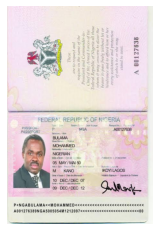

In [79]:
image = cv2.imread('images/passport27.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [80]:
net = cv2.dnn.readNet('model/yolov4-obj_last.weights', 'cfg/yolov4-obj.cfg')
blob = cv2.dnn.blobFromImage(image, scalefactor=0.00392, size=(416,416), mean=(0,0,0), swapRB=True, crop=False)
net.setInput(blob)

### Get output layer

In [81]:
output_layers = net.forward(get_output_layers(net))

### Remove Bounding Boxes With Low Confidence Using Non-Maxima Suppression

In [82]:
Height = image.shape[0]
Width = image.shape[1]

# Go through all the bounding boxes output from the network and keep only the ones with high confidence score
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

for output in output_layers:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > conf_threshold:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([round(x), round(y), round(w), round(h)])
            
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

In [83]:
classes_ = []

for ids in class_ids:
    class_ = classes[ids]
    classes_.append(class_)

In [84]:
for indice in indices:
    class_indice = classes_[indice]

### Optical Character Recognition (OCR)

In [85]:
# Crop the detected objects
text = []

for i in indices:
    indice = i
    box = boxes[i]
    (x, y, w, h) = box
    crop_img = image[y:y + h, x:x + w]
    
    # Save the cropped image
    cv2.imwrite('crop/' + classes_[indice] + '.jpg', crop_img)
    
    # Convert image to grayscale
    gray_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    
    # Resize the image to be three times the original size for better readability
    gray_img = cv2.resize(gray_img, (0,0), fx = 10, fy = 10, interpolation = cv2.INTER_CUBIC)
    
    # Perform Gaussian Blur to smoothen image
    blur = cv2.GaussianBlur(gray_img, (5,5), 0)
    
    # Use Otsu's thresholding to turn write up white and background black
    ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, rect_kernel)
    
    contours, hierachy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    sorted_contours = sorted(contours, key = lambda x: cv2.boundingRect(x)[0])
    
    for cnt in sorted_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
    roi = closing[y - 5:y + h + 5, x - 5:x + w + 5]
    # Use bitwise to flip image to black and background to white which is better for tesseract
    roi = cv2.bitwise_not(closing)

    # Save the Region of Interest (roi)
    cv2.imwrite('roi/' + classes_[indice] + '.jpg', roi)

In [98]:
img = cv2.imread('roi/Passport_No.jpg')
p_num = pytesseract.image_to_string(img, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ/'' --psm 8 --oem 3').strip()

In [99]:
p_num

'A00127638'

In [96]:
df_data = pd.read_csv('database.csv')
df_data.head()

,Passport_No,Offence,Fines ($),Paid/Unpaid,Wanted Status
0,A00127638,Drunk Driving,100,Unpaid,Wanted
1,A00127638,Over Speeding,50,Paid,Not_Wanted


In [97]:
df = df_data[df_data['Passport_No'] == p_num]
print(df)

  Passport_No        Offence  Fines ($) Paid/Unpaid Wanted Status
0   A00127638  Drunk Driving        100      Unpaid        Wanted
1   A00127638  Over Speeding         50        Paid    Not_Wanted
